In [199]:
import numpy as np
import pandas as pd
import re
import nltk
import nltk.data
from tqdm import tqdm
import pymorphy3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Uvarov.MN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [200]:
# Все новости. Ниже разделю их на тренировочную и тестовую выборки
# all_news = pd.DataFrame(pd.read_csv('result.csv'), columns=['title', 'text'])
# print("Всего новостей ", len(all_news))

all_news = pd.DataFrame(pd.read_csv('analisys_result.csv'), columns=['title', 'text', 'syntaxAnalisys'])
print("Всего новостей ", len(all_news))
# print(all_news.iloc[[1]])
# print(all_news.iloc[1,1])

Всего новостей  1684


In [201]:
print(all_news.iloc[[943]])

                                                 title  \
943  Georgian Airways запустит для россиян транзитн...   

                                                  text  \
943  «Начнем с 15 июня. Посмотрим, как пойдет это д...   

                                 syntaxAnalisys  
943  ('"', '«', 'punct', 'PUNCT', '->', Начнем)  


In [202]:
# Выбираем действующее лицо
all_persons = all_news['syntaxAnalisys']
person = all_persons[0]
person

"('проверка', 'Проверки', 'nsubj', 'NOUN', '->', проходят)"

In [203]:
# Тестоую выборку 50 новостей получаем рандомайзом. Дальше используем ее как основные новости
test = all_news.sample(n = 50, random_state=1)
print("Всего тестовой выборки " ,len(test))

Всего тестовой выборки  50


In [204]:
# Тренировочная быборка это все новости минус рандомно полученные тестовые новости 50 шт
news = pd.concat([all_news, test]).drop_duplicates(keep=False)
print("Всего чистых новостей, они же транировочные " ,len(news))

Всего чистых новостей, они же транировочные  1634


In [205]:
targets_ma = pd.Series(pd.read_csv('analisys_result.CSV')['theme'])
targets_ma

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1679    3.0
1680    3.0
1681    3.0
1682    3.0
1683    3.0
Name: theme, Length: 1684, dtype: float64

In [214]:
all_news_unicod = news.fit_transform(news['text'].values.astype('U'))

AttributeError: 'DataFrame' object has no attribute 'fit_transform'

In [212]:

%%time
# Считаем матрицу термин-документ, но не с частотами, а со значениями Tf*Idf
X = TfidfVectorizer().fit_transform(news['text'])
# Проводим SVD-разложение по 20 компонентам.
svd = TruncatedSVD(n_components=20)
X2 = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {int(explained_variance * 100)}%")
# Просто чтобы посмотреть, что там в самом деле вектора.
print(X2.shape, X2)

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
X

In [ ]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy3.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [ ]:
%%time
# Приведем слова в текстах к начальным формам.
news_texts['NText'] = news_texts['text'].map(lambda x:' '.join(normalizePymorphy(x)))

In [ ]:
%%time
X_l = TfidfVectorizer().fit_transform(news_texts['NText'])
svd = TruncatedSVD(n_components=10)
X2_l = svd.fit_transform(X)

In [ ]:
targets = np.array(targets)
targets

In [ ]:
def classify_texts(data, target):
    # Делим данные на обучающую и проверочную выборки.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=333)
    #Обучаем классификатор и оцениваем точность результатов.
    tree = RandomForestClassifier(criterion='entropy', random_state=333)
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    print(f"accuracy = {accuracy_score(y_hat, y_test)}")
    print(confusion_matrix(y_test, y_hat))

In [ ]:
classify_texts(X, targets)

In [ ]:
%%time
# TF*Idf с лемматизацией.
classify_texts(X_l, targets)

In [ ]:
%%time
# SVD без лемматизации.
classify_texts(X2, targets)

In [ ]:
%%time
# SVD с лемматизацией.
classify_texts(X2_l, targets)

In [ ]:
"""
dfdf
"""

In [ ]:
def text_to_sentences(text):
    # Функция делит текст на предложения, а предложения на слова.
    
    
    # Поделим текст на предложения при помощи NLTK.
    raw_sentences = nltk.sent_tokenize(str(text), language="russian")
    # Поделим предложения на слова при помощи регулярных выражений, заодно выкинем знаки препинания и цифры.
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(re.findall('[a-zA-Zа-яА-яёЁ]+', raw_sentence.lower()))
    return sentences

In [157]:
# пример на одной новости
text_to_sentences(news['text'][1])

[['мая',
  'церковь',
  'чтит',
  'память',
  'преподобной',
  'евфросинии',
  'в',
  'миру',
  'евдокии',
  'великой',
  'княгини',
  'московской'],
 ['в',
  'народе',
  'день',
  'носит',
  'название',
  'евдокии',
  'свистуньи',
  'считается',
  'что',
  'в',
  'это',
  'время',
  'ветры',
  'свистят'],
 ['с', 'днем', 'связан', 'ряд', 'примет'],
 ['какова', 'евдокия', 'таково', 'и', 'лето', 'говорили', 'крестьяне'],
 ['народившаяся',
  'в',
  'дождливую',
  'евдокию',
  'луна',
  'к',
  'мокрому',
  'лету',
  'а',
  'если',
  'еще',
  'дует',
  'северный',
  'ветер',
  'к',
  'лету',
  'холодному'],
 ['холодно',
  'днем',
  'летом',
  'будет',
  'частый',
  'град',
  'дождь',
  'идет',
  'лето',
  'будет',
  'мокрым'],
 ['дятел', 'стучит', 'в', 'ясный', 'день', 'скоро', 'пойдет', 'ливень'],
 ['свиньи', 'роют', 'грязь', 'носом', 'к', 'затяжному', 'дождю'],
 ['ворон', 'каркает', 'над', 'крышей', 'ночью', 'будет', 'холодно']]

In [158]:
all_sentences = [text_to_sentences(str(x)) for x in news['text']]
print(all_sentences[:1])
# all_sentenc1es = sum([text_to_sentences(x) for x in news['text']])
# all_sentences = sum([text_to_sentences(x) for x in news['text'].astype('string')])

[[['хабаровчане', 'провели', 'праздничную', 'неделю', 'под', 'музыку', 'военных', 'оркестров', 'со', 'всей', 'россии'], ['за', 'дней', 'на', 'площадках', 'состоялось', 'выступлений', 'которые', 'объединили', 'более', 'музыкантов', 'сообщает', 'иа', 'хабаровский', 'край', 'сегодня'], ['более', 'тысяч', 'зрителей', 'по', 'другую', 'сторону', 'экрана', 'собрала', 'онлайн', 'трансляция', 'фестиваля'], ['марш', 'парад', 'концерты', 'дефиле', 'представления', 'посетили', 'около', 'тысяч', 'человек'], ['амурские', 'волны', 'из', 'года', 'в', 'год', 'поражают', 'размахом'], ['это', 'яркое', 'весеннее', 'шоу', 'заполняющее', 'площади', 'и', 'улицы', 'города', 'звуками', 'живой', 'музыки', 'и', 'шумом', 'бурных', 'оваций', 'чтобы', 'в', 'xi', 'раз', 'удивить', 'искушенного', 'зрителя', 'краевой', 'столицы', 'режиссёры', 'привлекли', 'к', 'участию', 'в', 'фестивале', 'талантливых', 'артистов', 'хабаровска'], ['коллаборации', 'знакомых', 'и', 'любимых', 'исполнителей', 'с', 'оркестровым', 'звучани

In [159]:
all_sentences[0]

[['хабаровчане',
  'провели',
  'праздничную',
  'неделю',
  'под',
  'музыку',
  'военных',
  'оркестров',
  'со',
  'всей',
  'россии'],
 ['за',
  'дней',
  'на',
  'площадках',
  'состоялось',
  'выступлений',
  'которые',
  'объединили',
  'более',
  'музыкантов',
  'сообщает',
  'иа',
  'хабаровский',
  'край',
  'сегодня'],
 ['более',
  'тысяч',
  'зрителей',
  'по',
  'другую',
  'сторону',
  'экрана',
  'собрала',
  'онлайн',
  'трансляция',
  'фестиваля'],
 ['марш',
  'парад',
  'концерты',
  'дефиле',
  'представления',
  'посетили',
  'около',
  'тысяч',
  'человек'],
 ['амурские', 'волны', 'из', 'года', 'в', 'год', 'поражают', 'размахом'],
 ['это',
  'яркое',
  'весеннее',
  'шоу',
  'заполняющее',
  'площади',
  'и',
  'улицы',
  'города',
  'звуками',
  'живой',
  'музыки',
  'и',
  'шумом',
  'бурных',
  'оваций',
  'чтобы',
  'в',
  'xi',
  'раз',
  'удивить',
  'искушенного',
  'зрителя',
  'краевой',
  'столицы',
  'режиссёры',
  'привлекли',
  'к',
  'участию',
  'в'

In [160]:
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.

In [161]:
model_w2v = KeyedVectors.load_word2vec_format('araneum_upos_skipgram_300_2_2018.vec.gz')

In [162]:
model_w2v['огонь_NOUN']

array([-2.69010e-02,  1.08851e-01,  1.13100e-03, -2.76620e-02,
       -2.50680e-02, -4.58600e-03, -1.26100e-03, -3.79600e-03,
       -7.53080e-02, -2.39490e-02,  2.00400e-02,  6.10330e-02,
        7.40810e-02,  9.56330e-02, -1.11446e-01,  4.60380e-02,
       -2.24540e-02, -2.46080e-02, -8.82250e-02, -1.53180e-02,
       -3.66000e-04, -9.46770e-02,  1.33686e-01,  5.88400e-03,
       -5.05470e-02,  8.13820e-02, -2.88090e-02, -7.00070e-02,
        8.74950e-02, -8.31860e-02, -2.48210e-02, -3.82660e-02,
        6.13210e-02, -6.45530e-02,  2.66400e-03,  8.36140e-02,
       -3.73850e-02,  3.63260e-02, -1.20000e-04, -6.90000e-02,
        1.49810e-02,  3.03880e-02, -2.17280e-02,  2.79400e-02,
       -5.22550e-02,  1.96660e-02,  1.52499e-01,  7.27100e-02,
       -2.11140e-02,  5.69930e-02, -3.07870e-02,  4.09070e-02,
        6.49290e-02,  1.91730e-02,  2.50080e-02, -2.94090e-02,
        6.33780e-02,  1.09028e-01,  5.66630e-02, -3.62330e-02,
        4.96900e-02, -7.09280e-02,  2.74420e-02, -1.986

In [163]:
model_w2v.most_similar('огонь_NOUN')

[('пламень_NOUN', 0.678379476070404),
 ('пылать_VERB', 0.5475441813468933),
 ('потушить_VERB', 0.5439907312393188),
 ('тушить_VERB', 0.5375474095344543),
 ('зажигать_VERB', 0.5247330665588379),
 ('костер_NOUN', 0.5232465863227844),
 ('полыхать_VERB', 0.5192115306854248),
 ('негасимый_ADJ', 0.5050449371337891),
 ('шквальный_ADJ', 0.5008323788642883),
 ('гореть_VERB', 0.49952054023742676)]

In [164]:
list(model_w2v.key_to_index.keys())[:10]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN']

In [165]:
lens = np.array([np.linalg.norm(model_w2v[word]) for word in model_w2v.key_to_index.keys()])
lens[lens > 1.01], lens[lens < 0.99], lens[0]

(array([], dtype=float32), array([], dtype=float32), 0.99999964)

In [166]:
model_w2v.most_similar(positive=[u'сербия_PROPN', u'москва_PROPN' ], negative=[u'белград_PROPN'])

[('россия::москва_PROPN', 0.7317757606506348),
 ('россия_PROPN', 0.7260456681251526),
 ('москва::москва_PROPN', 0.7081453204154968),
 ('москва::россия_PROPN', 0.6551340818405151),
 ('россия::санкт-петербург_PROPN', 0.6160128712654114),
 ('рф::москва_PROPN', 0.6140520572662354),
 ('рязань_PROPN', 0.6115249991416931),
 ('россия::украина_PROPN', 0.6086370944976807),
 ('белоруссия_PROPN', 0.6031983494758606),
 ('москва::санкт-петербург_PROPN', 0.6031042337417603)]

In [167]:
import umap
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 12)

In [168]:
def get_most_frequent_words_from_model(model, texts, threshold=20):
    """ Функция выделяет слова, которые встречаются в текстах texts не реже, чем threshold раз,
        и при этом имеются в предобученной модели model. Также возвращает вектора этих слов.
    """
    vctr = CountVectorizer(lowercase=False)
    cntr = vctr.fit_transform(texts)
    
    res_words = []
    res_vects = []
    summed = cntr.sum(axis=0)
    klist = list(vctr.vocabulary_.keys())
    for i in range(summed.shape[1]):
        if summed[0, i] > threshold:
            try:
                res_vects.append(model[klist[i]])
                res_words.append(klist[i])
            except:
#                 print(klist[i])
                pass
    
    return res_words, res_vects

In [169]:
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy3.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', str(text))
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [170]:
sci_sentences = []
n_texts = []
for text in tqdm(news['text']):
    norm = normalizePymorphy(text)
    sci_sentences.append(norm)
    n_texts.append(' '.join(norm))

100%|██████████| 1634/1634 [00:09<00:00, 171.70it/s]


In [171]:
news['text'] = n_texts
news['text']

0       хабаровчанин_NOUN провести_VERB праздничный_AD...
1       май_NOUN церковь_NOUN чтить_VERB память_NOUN п...
2       путин_NOUN прокомментировать_VERB атака_NOUN б...
3       школьник_NOUN сдавать_VERB егэ_NOUN остальной_...
4       образ_NOUN архангел_NOUN михаил_NOUN святой_AD...
                              ...                        
1679    слово_NOUN посол_NOUN подрывать_VERB дух_NOUN ...
1680    лидер_NOUN турецкий_ADJ оппозиция_NOUN глава_N...
1681    касаться_VERB крупный_ADJ поставка_NOUN танк_N...
1682    свириденко_NOUN пояснить_VERB инициатива_NOUN ...
1683    вершинин_NOUN указать_VERB быть_VERB гарантия_...
Name: text, Length: 1634, dtype: object

In [172]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice



In [173]:
def cluster_texts_and_draw(vectors, umaped_vct, eps):
    """ Функция кластеризует вектора vectors при помощи DBSCAN, используя eps в качестве параметра,
        и отображает их на плоскость, используя umaped_vct.
    """
    # Кластеризуем данные при помощи DBSCAN. 
    # Это не значит, что он лучше k-Means, он просто здесь быстрее.
    db = DBSCAN(eps=eps, min_samples=3)
    db_clusters = db.fit_predict(vectors)
     # Генерируем контрастную карту цветов.
    myclr = ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1))
    print(max(db_clusters))
    fig, ax = plt.subplots()
    ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
    plt.show()
    return db_clusters

def show_texts_in_clusters(texts, target, clust_no, text_no):
    """ Функция отображает группировку текстов texts по кластсерам target.
        Выводит не более text_no текстов из первых clust_no кластеров.
    """

    clusters = list(set(target))

    for c in clusters[:clust_no]:
        print('          __ ', c, ' __')
        cntr = 0
        for i, a in enumerate(texts):
            if target[i] == c:
                print(a[:200])
                cntr += 1
                if cntr == text_no:
                    break
        print()
        
    

In [174]:
news_words, news_vects = get_most_frequent_words_from_model(model_w2v, news['text'], 10)
len(news_words)

2462

In [175]:
len(news_vects)

2462

In [176]:
# Кластеризуем, в среднем по два слова на кластер.

# news_clust_no = int(len(news_vects)/2)
sci_clust_no = int(len(news_vects)/2)
km_clustering = KMeans(n_clusters=sci_clust_no)
news_clusters = km_clustering.fit_predict(news_vects)


In [177]:
coi = 1
[word for word, clust in zip(news_words, news_clusters) if clust == coi]

['воевать_VERB']

In [178]:
news_words_sorted = sorted(zip(news_clusters, news_words), key= lambda x:x[0])
# sci_set = set(sci_words)
news_words_d = {w[1]:w[0] for w in news_words_sorted}

In [179]:
clust_no = 22
print([word[1] for word in news_words_sorted if word[0]==clust_no])

['фугас_NOUN', 'взрыватель_NOUN']


In [180]:
# Посчитаем координаты центроидов.
cur_clust = news_words_sorted[0][0]
cur_coord = np.array(model_w2v[news_words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(news_words_sorted[1:]):
    if cur_clust == news_words_sorted[i+1][0]:
        cur_coord += model_w2v[news_words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = news_words_sorted[i+1][0]
        cur_coord = np.array(model_w2v[news_words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)

In [181]:
def text_to_vec_centr(text, model_w2v, clust_coord, news_words_d):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in news_words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[news_words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, model_w2v[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [182]:
# Строим вектора для слов.
news_vect2 = []
for text in tqdm(news.text):
    news_vect2.append(text_to_vec_centr(text, model_w2v, clust_coord, news_words_d))

100%|██████████| 1634/1634 [00:08<00:00, 199.89it/s]


In [183]:
from umap.umap_ import UMAP

6


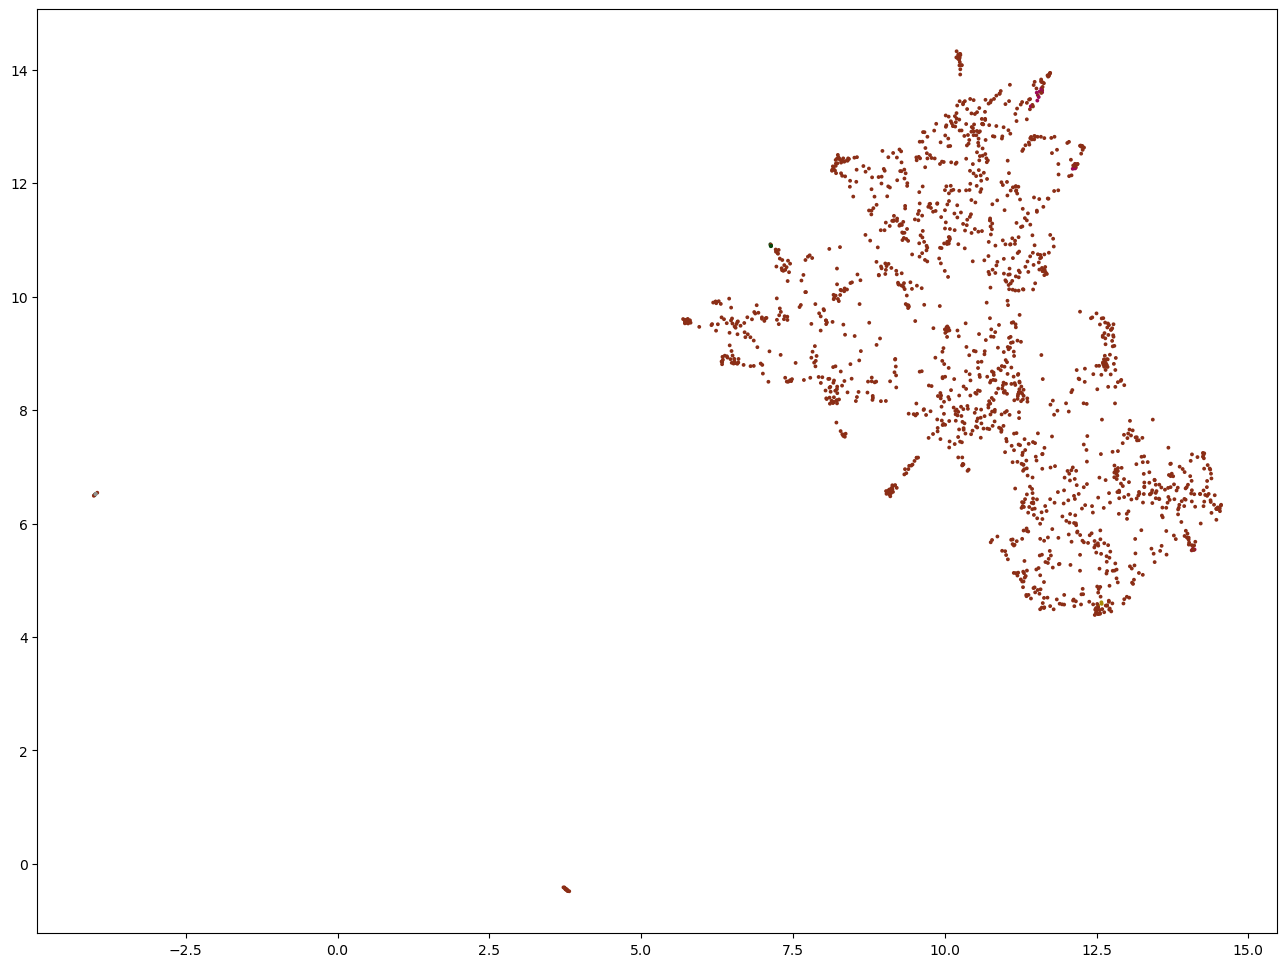

In [184]:
umaped_vct2 = UMAP().fit_transform(news_vect2)
clusters = cluster_texts_and_draw(news_vect2, umaped_vct2, 0.09)

In [185]:
show_texts_in_clusters(news.text, clusters, 10, 3)

          __  0  __
интересный_ADJ познавательный_ADJ тест_NOUN мочь_VERB
интересный_ADJ познавательный_ADJ тест_NOUN мочь_VERB
интересный_ADJ познавательный_ADJ тест_NOUN мочь_VERB

          __  1  __
олеся_NOUN маевский_NOUN интересный_ADJ познавательный_ADJ тест_NOUN мочь_VERB
олеся_NOUN маевский_NOUN интересный_ADJ познавательный_ADJ тест_NOUN мочь_VERB
олеся_NOUN маевский_NOUN интересный_ADJ познавательный_ADJ тест_NOUN мочь_VERB

          __  2  __
день_NOUN страна_NOUN зарегистрировать_VERB случай_NOUN заражение_NOUN смерть_NOUN весь_ADJ начало_NOUN пандемия_NOUN число_NOUN случай_NOUN выздоровление_NOUN коронавирус_NOUN увеличиться_VERB сутки_
день_NOUN страна_NOUN зарегистрировать_VERB случай_NOUN заражение_NOUN весь_ADJ начало_NOUN пандемия_NOUN смертность_NOUN ковид_NOUN россия_NOUN опуститься_VERB минимум_NOUN весна_NOUN год_NOUN сутки_
день_NOUN страна_NOUN зарегистрировать_VERB случай_NOUN заражение_NOUN смерть_NOUN весь_ADJ начало_NOUN пандемия_NOUN число_NOUN случай_N

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [187]:
def classify_texts(data, target):
    # Делим данные на обучающую и проверочную выборки.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=333)
    #Обучаем классификатор и оцениваем точность результатов.
    tree = RandomForestClassifier(criterion='entropy', random_state=333)
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    print(f"accuracy = {accuracy_score(y_hat, y_test)}")
    print(confusion_matrix(y_test, y_hat))

In [188]:
# Помещаем тестовую выборку в массив
targets = np.array(test)
len(targets)

50

In [189]:
len(news_vect2)

1634

In [190]:
type(news_vect2)

list

In [191]:
isNaN = np.isnan(news_vect2)
print(isNaN)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [192]:
classify_texts(news_vect2, targets)

ValueError: Found input variables with inconsistent numbers of samples: [1634, 50]